In [29]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import morphology, feature
import random

wr=False
wr=True
iterations=10

good=0
wrong=0
none=0

n=58
plt_m=6
plt_n=int(np.ceil(n/plt_m))
fsize=(20,35)
scale_percent = 60
#--------------------------------------
vars=21
buff_def=np.zeros(vars)
#--------------------------------------
buff_info=[ #step / min / max
    (0.05,0.75,1),(0.05,0,0.5),(0.05,0,0.5),(0.05,0.75,1),(0.00001,0.00001,0.0001), #border_1-5
    (1,70,95), #proc_lines_domination
    (1,1,10),(5,20,50), #min_sum_lines,min_lines_on_center
    (0.1,0.5,1.5),(0.1,0.5,1.5), #lh5,lv5
    (1,1,15),(1,1,15), #sq1,sq2

    (1,1,5),(2,10,250),(5,30,250),(5,30,250), #c_param_1-4
    (10,0,150),(10,0,150), #c_param_MinMaxRad

    (1,1,5),(5,30,100), #l_param_1-2
    (2,3,7) #canny
]

expected=[
    0,1,2,1,0,8,8,4,8,4,5,7,5,4,7,
    6,9,3,0,9,3,2,9,6,3,1,3,6,
    0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,
    5,5,5,6,6,6,7,7,7,8,8,8,9,9,9
]

def avg(x):
    return int(sum(x)/len(x))

def permut(n):
    tab1=list(range(n))
    tab2=[]
    dl=n-1
    for _ in range(n):
        x=random.randint(0, dl)
        tab2.append(tab1[x])
        tab1[x]=tab1[dl-1]
        dl-=1
    return tab2

def read():
    f=open("def_vars.txt",'r')
    s=f.readline()
    f.close()
    s=s.split(' ')
    return s

def save(tab):
    s1=read()
    f=open("buffs.txt",'a')
    f1=open("def_vars.txt",'w')
    
    s=""
    s1=""
    for i in range(vars):
        s+=str(tab[i])
        s1+=str(tab[i]+buff_def[i])
        s+=" "
        s1+=" "
        
        
    s+="\n"
    s1+="\n"
    
    f.write(s)
    f1.write(s1)
    
    f.close()
    f1.close()

def img2digit(img,buff):
    #for i in range(vars):
    #    buff[i]+=buff_def[i]
    
    [border_1,border_2,border_3,border_4,border_5,
    proc_lines_domination,
    min_sum_lines,min_lines_on_center,
    lh5,lv5,
    sq1,sq2,

    c_param_1,
    c_param_2,
    c_param_3,
    c_param_4,
    c_param_minRad,
    c_param_maxRad,

    l_param_1,
    l_param_2,
    can]=buff_def+buff
    #---------------------
    sq1=int(sq1)
    sq2=int(sq2)
    can=int(can)
    c_param_minRad=int(c_param_minRad)
    c_param_maxRad=int(c_param_maxRad)
    l_param_2=int(l_param_2)
    #---------------------
    
    
    number='none'
    lines_on_center=0
    circ_avg_x=0
    circ_avg_y=0

    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = morphology.erosion(img, morphology.square(sq1))
    img = morphology.dilation(img, morphology.square(sq2))
    dst = cv2.Canny(img, 50, 200, None, can)

    #----------------------------------------------------------
    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        c_param_1,
        c_param_2,
        param1=c_param_3,
        param2=c_param_4,
        minRadius=c_param_minRad,
        maxRadius=c_param_maxRad
    )
    num_of_circ=0
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
            #cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
        circ_avg_x=avg(circles[0,:,0])
        circ_avg_y=avg(circles[0,:,1])
        cv2.circle(img,(circ_avg_x,circ_avg_y),2,(0,255,255),10)
        num_of_circ=len(circles[0,:])

    img[int(height*(1/3)),:]=255
    img[int(height*(2/3)),:]=255
    #----------------------------------------------------------
    lines_H=0
    lines_V=0
    lines_slash=0
    lines_bslash=0

    lines = cv2.HoughLines(dst,l_param_1,np.pi/180,l_param_2)
    if lines is not None:
        for rho,theta in lines[:,0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            if circ_avg_x!=0:
                if(np.sin(theta)!=0):
                    tmp=int(rho/np.sin(theta) + circ_avg_x*(-(np.cos(theta)/np.sin(theta))))
                    if  tmp-(width*height*border_5) <= circ_avg_y <= tmp+(width*height*border_5):
                        lines_on_center+=1
            
            cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)

            if abs(a)<border_3:
                lines_H+=1
            elif abs(a)>border_4:
                lines_V+=1
            elif border_1>a>border_2:
                lines_slash+=1
            elif -border_1<a<-border_2:
                lines_bslash+=1
    #----------------------------------------------------------
    suma=sum([lines_H,lines_V,lines_slash,lines_bslash])
    
    if suma >= min_sum_lines:
        if num_of_circ==0:
            if ((lines_slash)/suma) >= proc_lines_domination:
                number=2
            elif ((lines_H+lines_slash)/suma) >= proc_lines_domination:
                number=7
            elif ((lines_V+lines_slash)/suma) >= proc_lines_domination:
                number=1
            else: number=4
            #print("Photo num ",sub-1,": ",lines_H,lines_V,lines_slash,lines_bslash)
        elif lines_on_center>=min_lines_on_center:
            number=8
        elif num_of_circ==1 and ((lh5*lines_H+lv5*lines_V)/suma) >= proc_lines_domination and not(circ_avg_y<(1/3)*height):
            number=5
    if number=="none":
        if num_of_circ==1:
            if circ_avg_y<(1/3)*height:
                number=9
            elif (1/3)*height<circ_avg_y<(2/3)*height:
                number=0
            else:
                number=6
        elif num_of_circ==2:
            number=3
    return (img,number)
    #----------------------------------------------------------



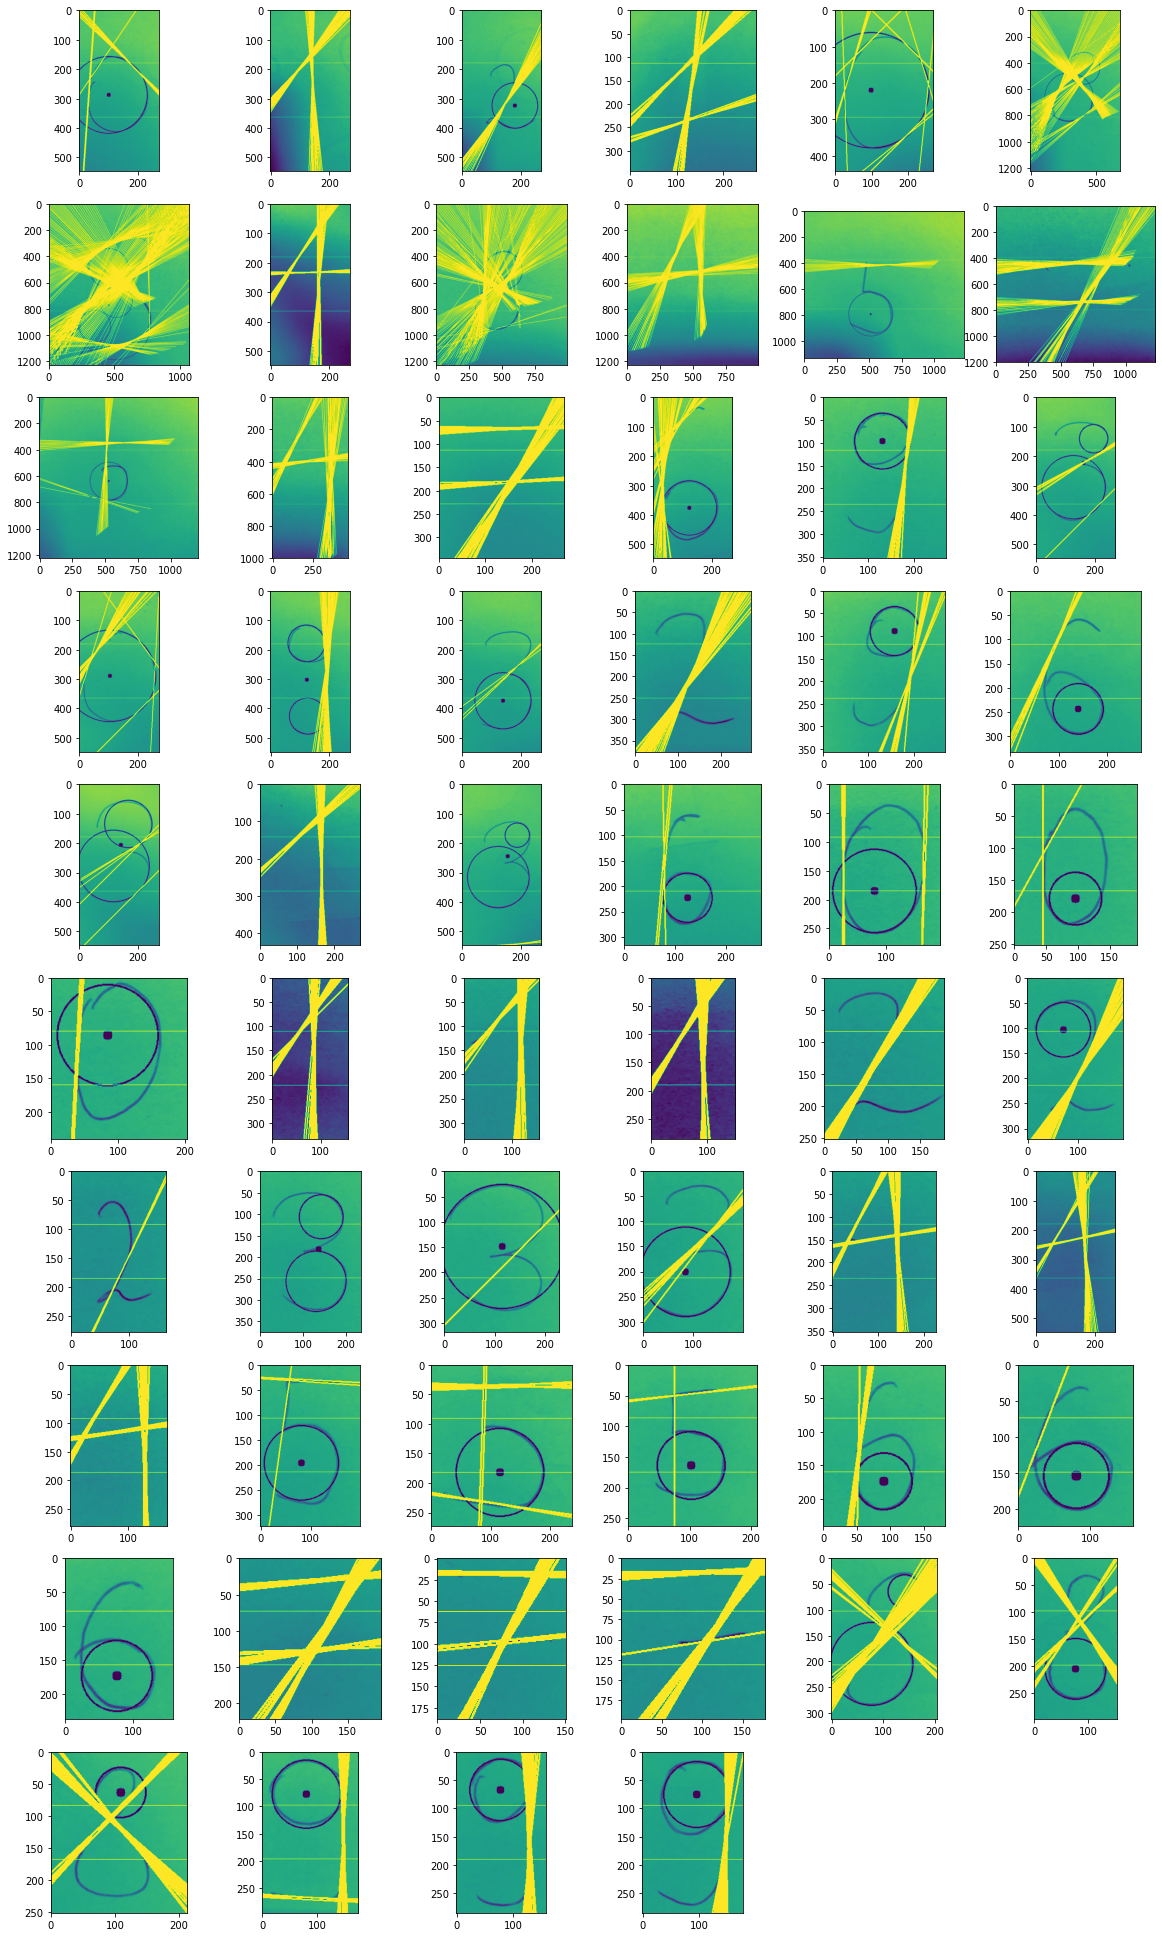

def_good: 49 	def_wrong: 9 	def_none:  0


In [30]:
def look4digits(wr,buff):
    global good,wrong,none
    pictures=[]
    for i in range(n):
        tmp=str(i)
        if(i<10):
            tmp='0'+tmp
        pictures.append(tmp)

    if wr==1:
        plt.figure(figsize=fsize)
    sub=1
    good=0
    wrong=0
    none=0

    for pic in pictures:
        if wr==1:
            plt.subplot(plt_n,plt_m,sub)
        image=cv2.imread('data/calc_'+pic+'.jpg')
        img,number=img2digit(image,buff)

        tmp=str(sub-1)
        if(sub-1<10):
            tmp='0'+tmp
        
        if number==expected[sub-1]:
            status='ok'
            good+=1
        elif number=="none":
            status='none'
            none+=1
        else:
            status='error'
            wrong+=1
        #if(status!='ok'):
            #print("Photo num",tmp,"is: ",number,"\t expected: ",expected[sub-1],status)
        
        if wr==1:
            plt.imshow(img)
        sub+=1
        
    if wr==1:
        plt.show()

def main():
    s=read()
    for i in range(vars):
        buff_def[i]=float(s[i])
    
    buff=np.zeros(vars)
    look4digits(wr,buff) #1 - write

    def_good=good
    def_wrong=wrong
    def_none=none
    global_best=def_good
    print("def_good:",def_good,"\tdef_wrong:",def_wrong,"\tdef_none: ",def_none)
    
    while(not wr):
        order=permut(vars)
        for _ in range(iterations): 
            for j in order:
                best=def_good
                best_state=buff[j]
                
                interval=buff_info[j][2]-buff_info[j][1]
                steps=int((interval)/buff_info[j][0])+1
                    
                for k in range(steps):
                    #print(j,buff[j],buff_info[j][1]+k*buff_info[j][0]-buff_def[j])
                    buff[j]=buff_info[j][1]+k*buff_info[j][0]-buff_def[j]
                    look4digits(wr,buff)
                    if good >= best:
                        best_state=buff[j]
                    if good > global_best:
                        global_best=good
                        print("good:",good,"\twrong:",wrong,"\tnone: ",none)
                        print("NICE!\n",buff)
                        save(buff)
                        #print("good:",good,"\twrong:",wrong,"\tnone: ",none,'\t\t',j,buff[j],buff_def[j],k)
                buff[j]=best_state
                #print(buff)
        buff=np.zeros(vars)
                
    
if __name__=='__main__':
    main()